# Logistic regression

This notebook aims to implement logistic regression in order to classify music pulled from my spotify account which I have classified as 1 for like and 0 for dislike.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from log_reg import *

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.set_printoptions(precision=3)

# make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

## Data gathering

First we must read the data from a csv into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and get a sense of what all the data means. A complete list of what each feature means can be found [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

In [2]:
df = pd.read_csv('data.csv')
df.head()

,name,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,like
0,Marry Me,0.113,https://api.spotify.com/v1/audio-analysis/0OWZ...,0.588,205453,0.408,0OWZFobGSIW9GrSlQ9C5pc,0.000000,3,0.1300,-8.662,1,0.0237,85.008,4,https://api.spotify.com/v1/tracks/0OWZFobGSIW9...,audio_features,spotify:track:0OWZFobGSIW9GrSlQ9C5pc,0.4840,1.0
1,Is It Really Me You're Missing,0.653,https://api.spotify.com/v1/audio-analysis/1WO6...,0.535,232800,0.297,1WO6kvO7P8TOsuhBaqun5w,0.000000,6,0.1180,-6.043,1,0.0665,147.569,4,https://api.spotify.com/v1/tracks/1WO6kvO7P8TO...,audio_features,spotify:track:1WO6kvO7P8TOsuhBaqun5w,0.0492,1.0
2,Hollow Crown,0.103,https://api.spotify.com/v1/audio-analysis/15ba...,0.620,171320,0.564,15baNmdl3WSqSKnT0YDG2v,0.000000,8,0.0735,-7.090,1,0.0392,150.034,4,https://api.spotify.com/v1/tracks/15baNmdl3WSq...,audio_features,spotify:track:15baNmdl3WSqSKnT0YDG2v,0.3010,1.0
3,A Big World,0.312,https://api.spotify.com/v1/audio-analysis/4vhW...,0.394,186681,0.505,4vhW66VGfINDEOssckYMIW,0.000000,7,0.2680,-7.638,1,0.0473,109.446,4,https://api.spotify.com/v1/tracks/4vhW66VGfIND...,audio_features,spotify:track:4vhW66VGfINDEOssckYMIW,0.2550,1.0
4,Roman Sky,0.139,https://api.spotify.com/v1/audio-analysis/1hy6...,0.455,300361,0.420,1hy6eKT3JRhi3ODXpL8Ubu,0.000033,2,0.1010,-8.731,0,0.0297,130.045,4,https://api.spotify.com/v1/tracks/1hy6eKT3JRhi...,audio_features,spotify:track:1hy6eKT3JRhi3ODXpL8Ubu,0.1010,1.0


In [3]:
df.drop(columns=['analysis_url', 'id', 'track_href', 'type', 'uri', 'name'], inplace=True)

In [4]:
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,like
0,0.113,0.588,205453,0.408,0.000000,3,0.1300,-8.662,1,0.0237,85.008,4,0.4840,1.0
1,0.653,0.535,232800,0.297,0.000000,6,0.1180,-6.043,1,0.0665,147.569,4,0.0492,1.0
2,0.103,0.620,171320,0.564,0.000000,8,0.0735,-7.090,1,0.0392,150.034,4,0.3010,1.0
3,0.312,0.394,186681,0.505,0.000000,7,0.2680,-7.638,1,0.0473,109.446,4,0.2550,1.0
4,0.139,0.455,300361,0.420,0.000033,2,0.1010,-8.731,0,0.0297,130.045,4,0.1010,1.0


## The Sigmoid function

In logistic regression, rather than trying to predict continuous value like in linear regression, we try to predict the class of an instance. In this case the class is whether I like a song or not (a 1 or a 0 respectively). Therefore we use the sigmoid function which we can use as a probability for which class we belong to.

The Sigmoid function: 
$$
S(x) = \frac{1}{1 + e^{-x}}
$$

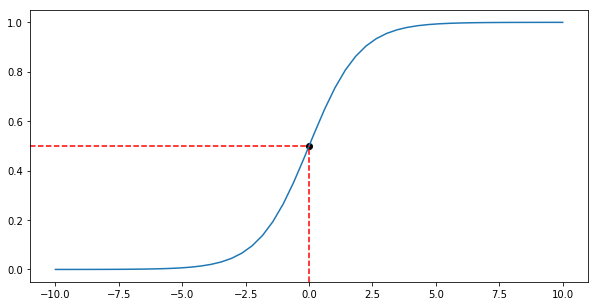

In [5]:
x = np.linspace(-10, 10)
y = sigmoid(x)

plt.figure(figsize=(10,5))
plt.plot(x, y);
plt.scatter(0, .5, color='black')
plt.axhline(y=.5,xmin=0, xmax=0.5, color='red', linestyle='--')
plt.axvline(x=0, ymin=0, ymax=.5, color='red', linestyle='--');

As we can see there are some nice properties to the sigmoid function such as its range is **(0,1)** which allows us to map instances to a probability of belonging to either class 0 or class 1. Just as in Linear Regression we will try to learn the paramteters of a linear prediction function: 
$$
\hat{y} = h_\theta(x) = \theta^T x = \theta_0 + \theta_1 x_1
$$

But now that we are trying to predict the class we will apply the sigmoid function to our hypothesis. So our new hypothesis will be:
$$
h_\theta(x) = S(\theta^T x) = \frac{1}{1 + e^{-\theta^T x}}
$$


and our decision rule will be predict class 1 if $S(\theta^T x) >= 0.5$ otherwise class 0.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1].values, df.like.values, test_size=.30)

In [7]:
X_train.shape, y_train.shape

((336, 13), (336,))

## Preprocessing and bias trick

As the number of features grows, calculating gradients gets computationally expensive. We can speed this up by normalizing the input data to ensure all values are within the same range. This is especially important for datasets with high standard deviations or differences in the ranges of the attributes. We can do this by either min-max scaling or mean normalization. Both will scale the features down to the range **[0,1]** while mean normalization will also ensure the features have a standard deviation of 1

As in Linear Regression we must make sure that `X` takes into consideration the bias $\theta_0$ in the linear model. Recall that the predications of our linear model are of the form:

$$
\hat{y} = \theta^T x = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n 
$$

Add columns of ones as the zeroth column of `X`.

In [8]:
# First we preprocess the X sets then we add the column of ones
X_train= min_max_scale(X_train)
X_test = min_max_scale(X_test)

# X_train= standaradize(X_train)
# X_test = standaradize(X_test)

X_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
X_test = np.column_stack((np.ones(X_test.shape[0]), X_test))

## Gradient Descent 

Our task is to find the best possible line that explains all the points in our dataset when mapped to the sigmoid function. We start by guessing initial values for the linear regression parameters $\theta$ and updating the values using gradient descent. 

The objective of logistic regression is to minimize the cost function $J$:

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m}[y^{(i)}\ln{(h_\theta(x^{(i)}))} + (1 - y^{(i)})\ln{(1 - h_\theta(x^{(i)}))}]
$$

where the hypothesis (model) $h_\theta(x)$ is given by:

$$
h_\theta(x) = S(\theta^T x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$\theta_j$ are the parameters of your model and by changing those values accordingly, you will be able to lower the cost function $J(\theta)$. We can accopmlish this by using gradient descent:

$$
\theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}
$$


In [9]:
theta = np.random.random(size=X_train.shape[1])
theta

array([0.311, 0.98 , 0.175, 0.017, 0.763, 0.807, 0.346, 0.465, 0.65 ,
       0.048, 0.949, 0.887, 0.261, 0.015])

In [10]:
compute_cost(X_train, y_train, theta)

1.2462065076739288

In [11]:
theta, j_history = gradient_descent(X_train, y_train, theta, .03, 40_000)
theta

array([ 3.677,  2.161,  2.985,  2.715, -5.776,  0.855, -0.008, -0.789,
       -2.08 , -0.583, -0.009,  0.212,  2.103, -2.546])

### Plotting the results

After we train the model and get the best theta we can plot the cost as a function of each new iteration improving theta.

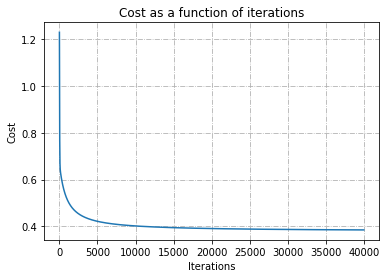

In [12]:
plt.plot(j_history)
plt.title('Cost as a function of iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(linestyle='-.')

In [13]:
compute_accuracy(X_test, y_test, theta)

73.61

## Finding the best Alpha

We now compare different alpha values to see which one gives the best final loss.

In [14]:
alpha_costs = compare_alpha_costs(X_train, y_train, 40_000)

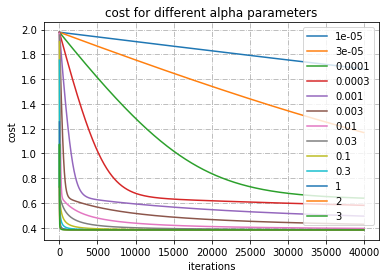

In [15]:
plt.title('cost for different alpha parameters')
plt.xlabel('iterations')
plt.ylabel('cost')
plt.grid(linestyle='-.')
for alpha, loss in alpha_costs.items():
    plt.plot(loss, label=alpha)
plt.legend()
plt.show()

In [16]:
alpha_dict = {alpha: loss[-1] for alpha, loss in alpha_costs.items()}
alpha_dict

{1e-05: 1.6827060471056385,
 3e-05: 1.1687153466574363,
 0.0001: 0.638963438035716,
 0.0003: 0.5811256195884617,
 0.001: 0.4940574096498069,
 0.003: 0.4282158956332348,
 0.01: 0.3948329109159667,
 0.03: 0.38483025047572117,
 0.1: 0.38272699390437803,
 0.3: 0.3826335178047121,
 1: 0.3826332015737976,
 2: 0.38263320157379693,
 3: 0.38263320157379704}

In [17]:
loss_values = sorted(alpha_dict.items(), key=lambda tup: tup[1])
loss_values

[(2, 0.38263320157379693),
 (3, 0.38263320157379704),
 (1, 0.3826332015737976),
 (0.3, 0.3826335178047121),
 (0.1, 0.38272699390437803),
 (0.03, 0.38483025047572117),
 (0.01, 0.3948329109159667),
 (0.003, 0.4282158956332348),
 (0.001, 0.4940574096498069),
 (0.0003, 0.5811256195884617),
 (0.0001, 0.638963438035716),
 (3e-05, 1.1687153466574363),
 (1e-05, 1.6827060471056385)]

In [18]:
best_alpha = loss_values[0][0]
best_alpha

2

#### We've now found the optimal alpha parameter which we can use for gradient descent.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1].values, df.like.values, test_size=.30)
# First we preprocess the X sets then we add the column of ones
X_train= min_max_scale(X_train)
X_test = min_max_scale(X_test)

# X_train= standaradize(X_train)
# X_test = standaradize(X_test)

X_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
X_test = np.column_stack((np.ones(X_test.shape[0]), X_test))

In [20]:
theta = np.random.random(size=X_train.shape[1])
theta

array([0.768, 0.087, 0.506, 0.932, 0.321, 0.594, 0.369, 0.454, 0.549,
       0.549, 0.202, 0.685, 0.088, 0.139])

In [21]:
compute_cost(X_train, y_train, theta)

1.4406563991282415

In [22]:
theta, j_history = gradient_descent(X_train, y_train, theta, best_alpha, 40_000)
theta

array([ 2.456,  0.363,  1.84 ,  1.911, -7.763,  0.679, -0.511, -0.289,
        1.669, -0.55 ,  1.14 ,  0.224,  1.504, -1.272])

In [23]:
compute_cost(X_train, y_train, theta)

0.447482878225035

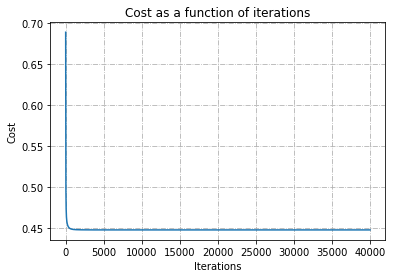

In [24]:
plt.plot(j_history)
plt.title('Cost as a function of iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(linestyle='-.')

In [25]:
compute_accuracy(X_test, y_test, theta)

77.08